# About this notebook
- PyTorch efficientnet_b0 with W&B starter code
- Pytorch W&B Usage Examples from https://docs.wandb.ai/guides/integrations/pytorch

If this notebook is helpful, feel free to upvote :)

In [1]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [3]:
timm.list_models('vit*')

['vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_clip_224',
 'vit_giant_patch14_dinov2',
 'vit_gigantic_patch14_224',
 'vit_gigantic_patch14_clip_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_clip_224',
 'vit_huge_patch14_clip_336',
 'vit_huge_patch14_xp_224',
 'vit_large_patch14_224',
 'vit_large_patch14_clip_224',
 'vit_large_patch14_clip_336',
 'vit_large_p

In [4]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=10
    num_workers=4
    size=224
    model_name='vit_large_patch32_224'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=40
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=[42, 10, 20, 51, 111]
    target_size=1
    target_col='KIc'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    grad_cam=True
    

In [5]:
df = pd.read_csv('~/KIc/vgg16_KIC/inout_data.csv', header=None, names=['Id', 'KIc'])
df['file_path'] = ['./KIc/imagedata/1' + str(i).zfill(5) + '.jpg' for i in df['Id']]
train = df

# train, test = train_test_split(df, test_size=0.1, random_state=CFG.seed)
# train.reset_index(inplace=True, drop=True)
# test.reset_index(inplace=True, drop=True)

display(train.head())
# display(test.head())

if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=100, random_state=CFG.seed).reset_index(drop=True)

Id   KIc                   file_path
0  95  3.55  ./KIc/imagedata/100095.jpg
1  96  3.74  ./KIc/imagedata/100096.jpg
2  97  3.68  ./KIc/imagedata/100097.jpg
3  98  3.72  ./KIc/imagedata/100098.jpg
4  99  3.61  ./KIc/imagedata/100099.jpg

# Quick EDA

<Axes: >

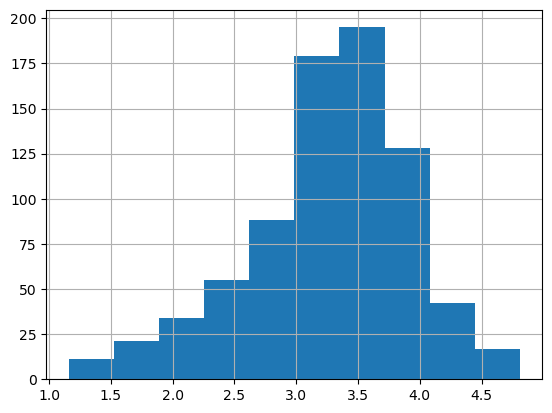

In [6]:
train['KIc'].hist()

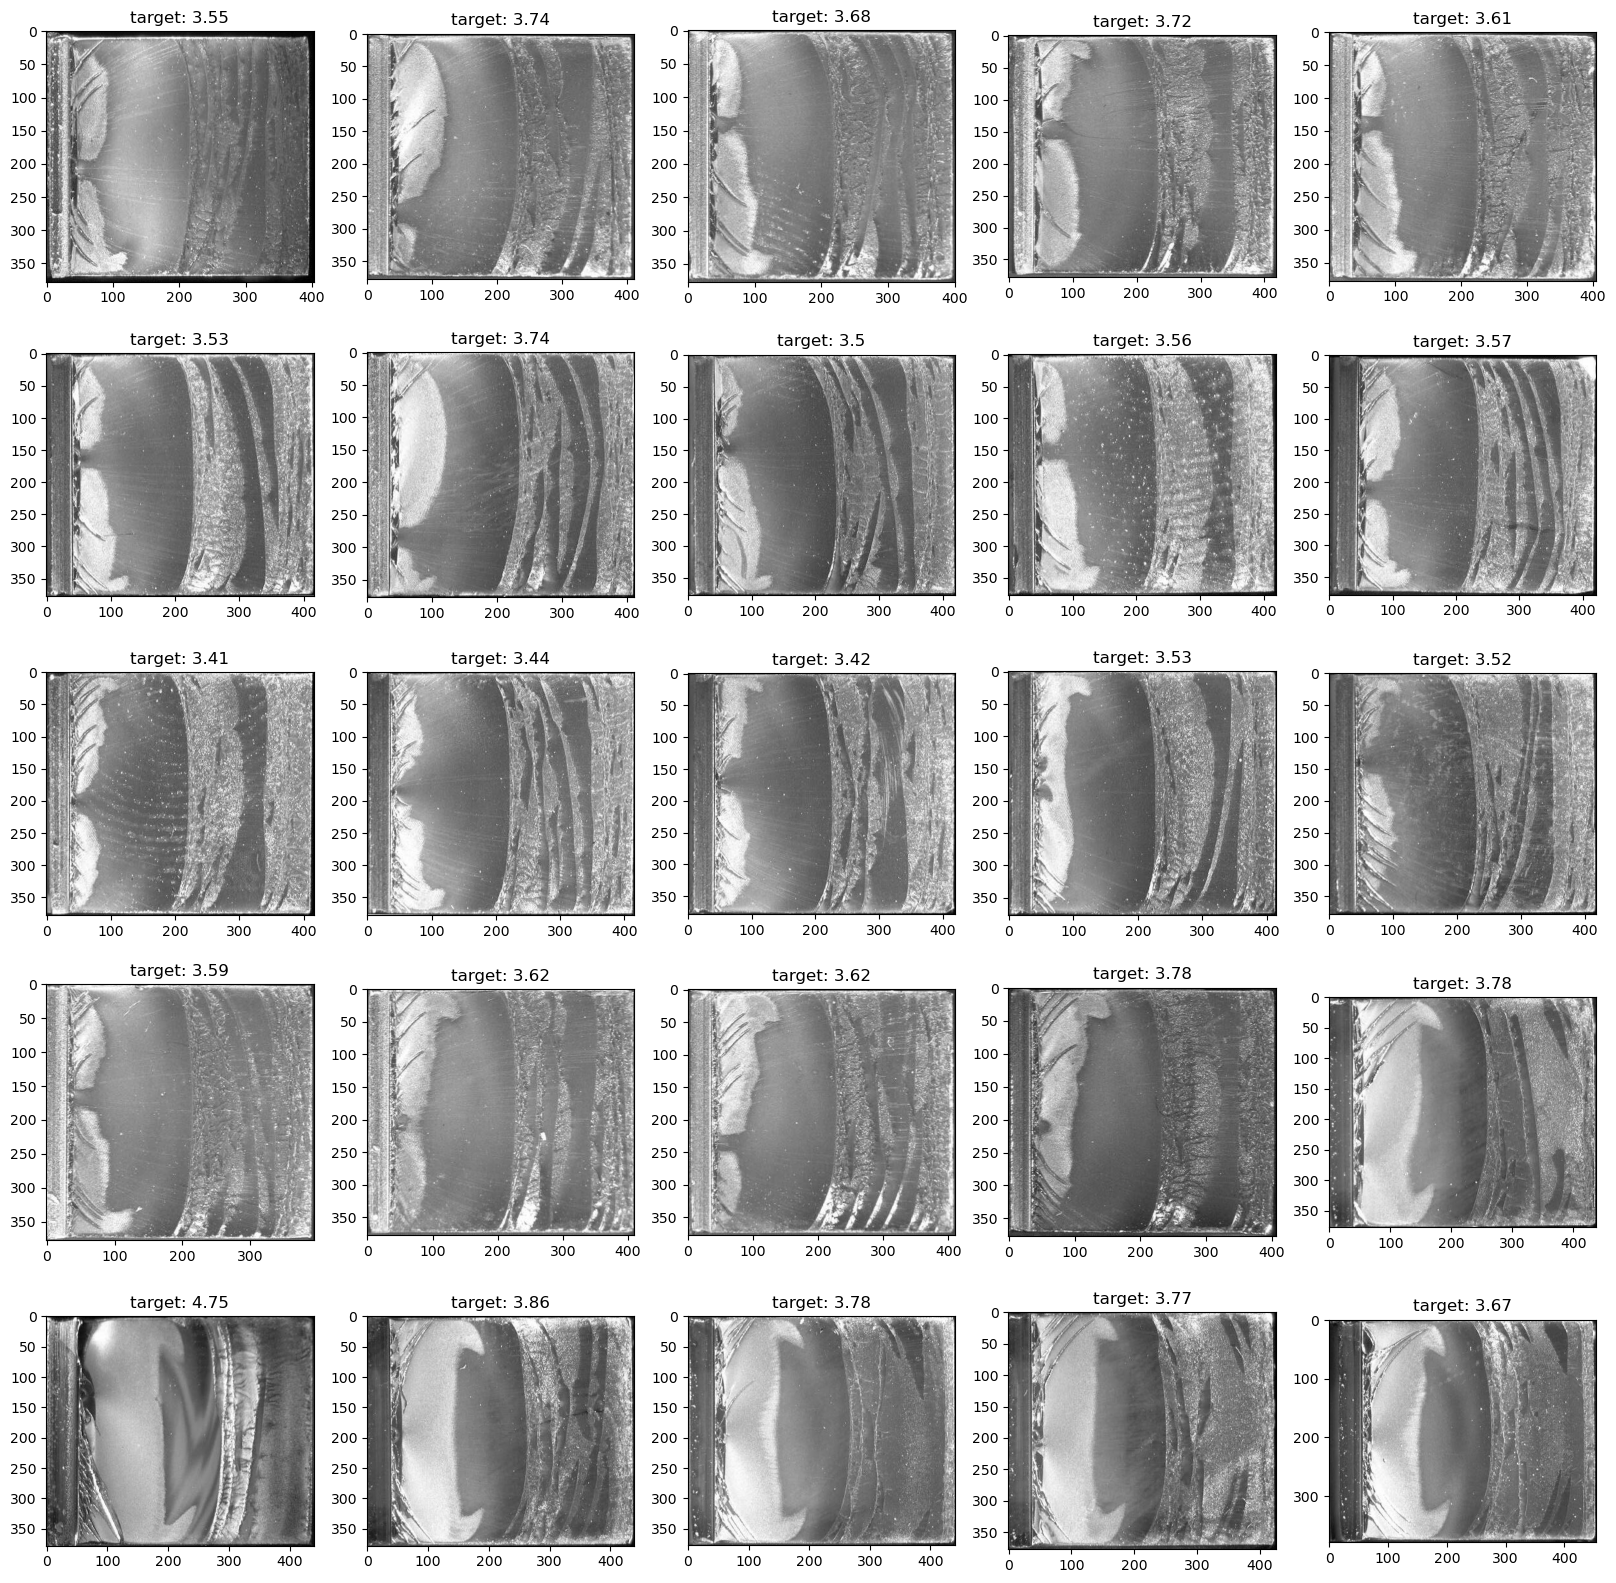

In [7]:
plt.figure(figsize=(20, 20))
row, col = 5, 5
for i in range(row * col):
    plt.subplot(col, row, i+1)
    image = cv2.imread(train.loc[i, 'file_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = train.loc[i, 'KIc']
    plt.imshow(image)
    plt.title(f"target: {target}")
plt.show()

# Directory settings

In [8]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

# Library

# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



# CV split

In [10]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)

Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', "bins"]).size())

fold  bins
0     0        2
      1        5
      2        6
      3       11
      4       17
      5       36
      6       39
      7       26
      8        9
      9        3
1     0        2
      1        4
      2        7
      3       11
      4       17
      5       36
      6       39
      7       26
      8        9
      9        3
2     0        2
      1        4
      2        7
      3       11
      4       18
      5       36
      6       39
      7       26
      8        8
      9        3
3     0        2
      1        4
      2        7
      3       11
      4       18
      5       36
      6       39
      7       25
      8        8
      9        4
4     0        3
      1        4
      2        7
      3       11
      4       18
      5       35
      6       39
      7       25
      8        8
      9        4
dtype: int64

In [11]:
train.to_pickle(OUTPUT_DIR+'train.pkl')

# Dataset

In [12]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

    
class GradCAMDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_ids = df['Id'].values
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = get_transforms(data='valid')
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        vis_image = cv2.resize(image, (CFG.size, CFG.size)).copy()
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image_id, image, vis_image, label

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

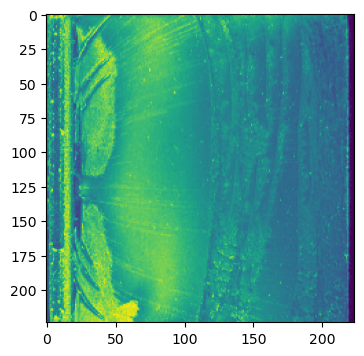

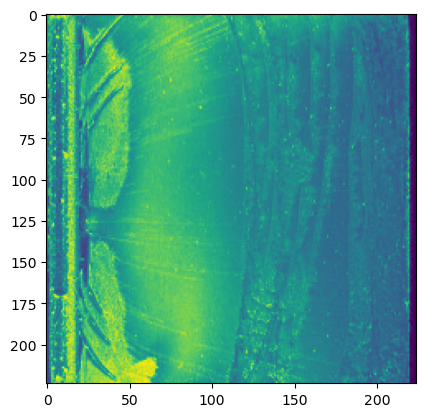

torch.Size([3, 224, 224])


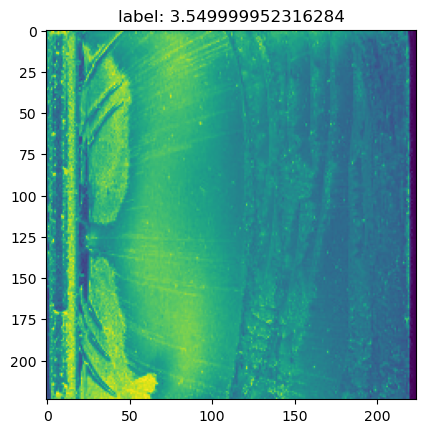

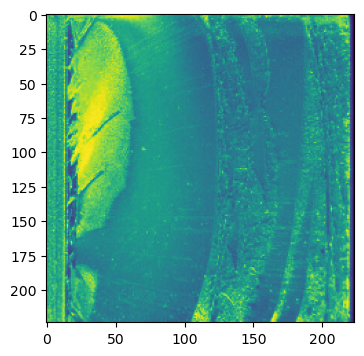

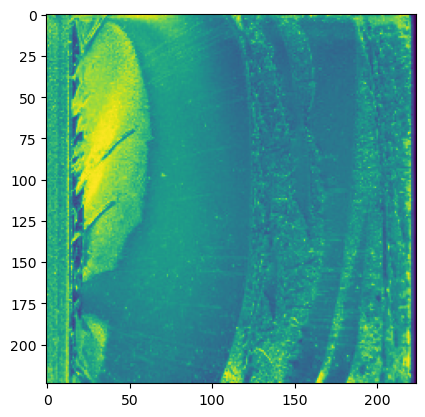

torch.Size([3, 224, 224])


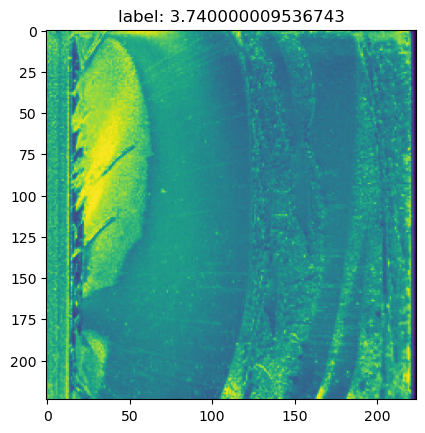

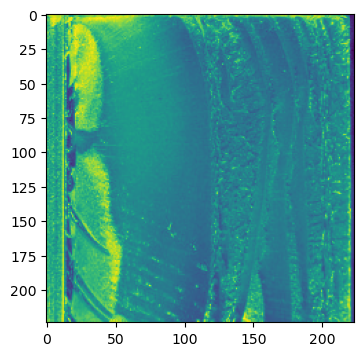

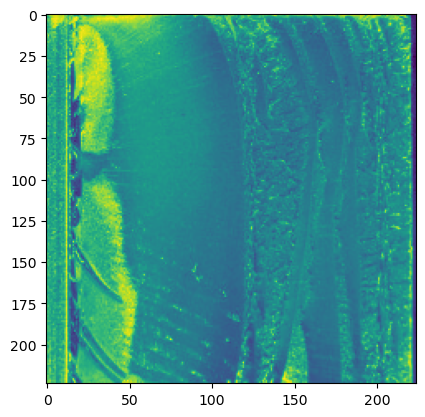

torch.Size([3, 224, 224])


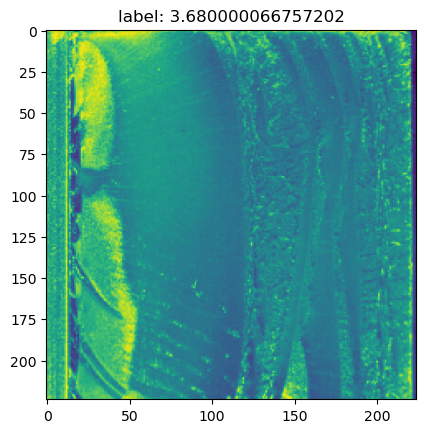

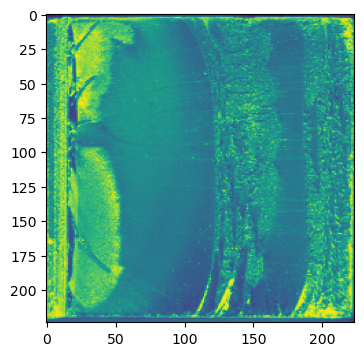

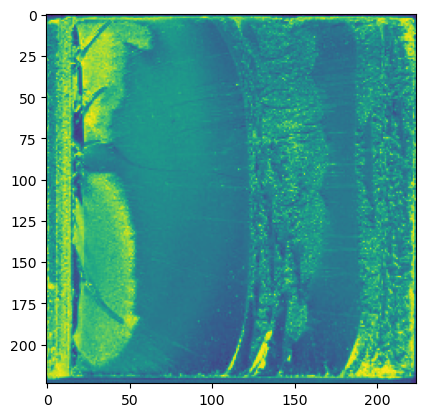

torch.Size([3, 224, 224])


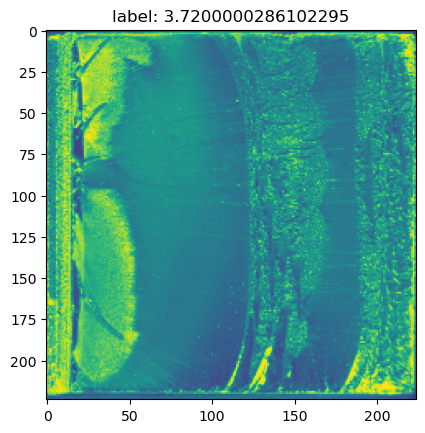

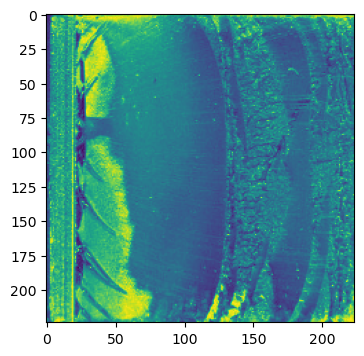

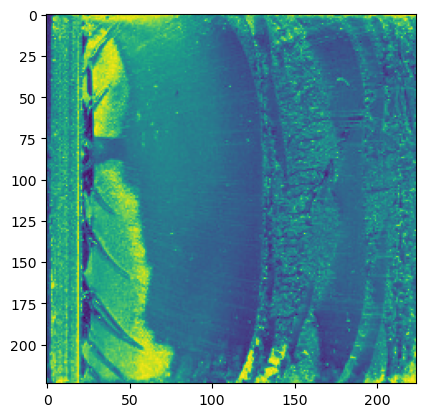

torch.Size([3, 224, 224])


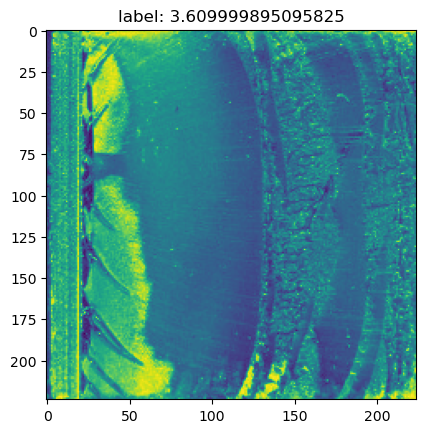

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(4, 4))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.show() 
    plt.imshow(image[1])
    plt.show() 
    plt.imshow(image[2])
    print(image.shape)
    plt.title(f'label: {label}')
    plt.show() 

# MODEL

In [15]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        self.n_features = self.model.head.in_features
        self.model.head = nn.Identity()
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

# Loss

In [16]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Helper functions

In [17]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))

    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    losses = AverageMeter()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [18]:
def get_grad_cam(model, device, x_tensor, img, label, plot=False):
    result = {"vis": None, "img": None, "pred": None, "label": None}
    print("x_tensor", x_tensor.shape)
    print("x_tensor", x_tensor.unsqueeze(0).shape)
    with torch.no_grad():
        pred = model(x_tensor.unsqueeze(0).to(device))
#         pred = model(x_tensor.to(device))
    pred = np.concatenate(pred.to('cpu').numpy())[0]
    target_layer = [model.model.blocks[-1].norm1]
    cam = GradCAM(model=model, target_layers=target_layer, use_cuda=torch.cuda.is_available())
    from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget
#     targets = [RawScoresOutputTarget()]
    targets = None
    output = cam(input_tensor=x_tensor.unsqueeze(0).to(device), targets=targets)
#     output = cam(input_tensor=x_tensor.to(device))
    try:
        vis = show_cam_on_image(img / 255., output[0])
    except:
        return result
    if plot:
        fig, axes = plt.subplots(figsize=(8, 8), ncols=2)
        axes[0].imshow(vis)
        axes[0].set_title(f"pred={pred:.4f}")
        axes[1].imshow(img)
        axes[1].set_title(f"target={label}")
        plt.show()
    result = {"vis": vis, "img": img, "pred": pred, "label": label}
    torch.cuda.empty_cache()
    return result

# Train loop

In [19]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = RMSELoss()

    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
       
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_seed{seed}_best.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_seed{seed}_best.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [20]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        for seed in CFG.seed:
            seed_torch(seed=seed)
            # train 
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(train, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            # save result
            oof_df.to_csv(OUTPUT_DIR+f'{CFG.model_name}_seed{seed}_oof_df.csv', index=False)

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


Epoch: [1][0/19] Elapsed 0m 1s (remain 0m 35s) Loss: 3.3917(3.3917) Grad: 3.3658  LR: 0.000100  
Epoch: [1][10/19] Elapsed 0m 4s (remain 0m 3s) Loss: 0.7060(1.6558) Grad: 1.4912  LR: 0.000100  
Epoch: [1][18/19] Elapsed 0m 6s (remain 0m 0s) Loss: 0.5510(1.2270) Grad: 2.0127  LR: 0.000100  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.6463(0.6463) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.5836(0.6466) 


Epoch 1 - avg_train_loss: 1.2270  avg_val_loss: 0.6466  time: 7s
Epoch 1 - Score: 0.6473
Epoch 1 - Save Best Score: 0.6473 Model


Epoch: [2][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.7298(0.7298) Grad: 2.1799  LR: 0.000057  
Epoch: [2][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.5670(0.6307) Grad: 0.9280  LR: 0.000057  
Epoch: [2][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5206(0.6076) Grad: 1.4428  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.5477(0.5477) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4626(0.5483) 


Epoch 2 - avg_train_loss: 0.6076  avg_val_loss: 0.5483  time: 5s
Epoch 2 - Score: 0.5499
Epoch 2 - Save Best Score: 0.5499 Model


Epoch: [3][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.4948(0.4948) Grad: 2.8215  LR: 0.000009  
Epoch: [3][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.5281(0.5293) Grad: 2.5994  LR: 0.000009  
Epoch: [3][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3605(0.5026) Grad: 0.9678  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.5067(0.5067) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4472(0.5304) 


Epoch 3 - avg_train_loss: 0.5026  avg_val_loss: 0.5304  time: 5s
Epoch 3 - Score: 0.5330
Epoch 3 - Save Best Score: 0.5330 Model


Epoch: [4][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.4599(0.4599) Grad: 1.3027  LR: 0.000001  
Epoch: [4][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.2868(0.4743) Grad: 2.0743  LR: 0.000001  
Epoch: [4][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5116(0.4676) Grad: 2.3003  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.5025(0.5025) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4314(0.5151) 


Epoch 4 - avg_train_loss: 0.4676  avg_val_loss: 0.5151  time: 5s
Epoch 4 - Score: 0.5172
Epoch 4 - Save Best Score: 0.5172 Model


Epoch: [5][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.4427(0.4427) Grad: 2.9933  LR: 0.000050  
Epoch: [5][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.4223(0.4636) Grad: 4.0989  LR: 0.000050  
Epoch: [5][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.4873(0.4424) Grad: 2.7886  LR: 0.000050  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.5034(0.5034) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4193(0.5122) 


Epoch 5 - avg_train_loss: 0.4424  avg_val_loss: 0.5122  time: 5s
Epoch 5 - Score: 0.5145
Epoch 5 - Save Best Score: 0.5145 Model


Epoch: [6][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.4538(0.4538) Grad: 3.3263  LR: 0.000224  
Epoch: [6][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.3044(0.4265) Grad: 1.3309  LR: 0.000224  
Epoch: [6][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3699(0.4046) Grad: 2.2112  LR: 0.000224  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4627(0.4627) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.3275(0.4520) 


Epoch 6 - avg_train_loss: 0.4046  avg_val_loss: 0.4520  time: 5s
Epoch 6 - Score: 0.4557
Epoch 6 - Save Best Score: 0.4557 Model


Epoch: [7][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3576(0.3576) Grad: 0.8726  LR: 0.000133  
Epoch: [7][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.4407(0.3771) Grad: 2.0210  LR: 0.000133  
Epoch: [7][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3622(0.3639) Grad: 1.7549  LR: 0.000133  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.5071(0.5071) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.3327(0.4856) 


Epoch 7 - avg_train_loss: 0.3639  avg_val_loss: 0.4856  time: 5s
Epoch 7 - Score: 0.4905


Epoch: [8][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.4032(0.4032) Grad: 2.1167  LR: 0.000057  
Epoch: [8][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.2296(0.3393) Grad: 2.2577  LR: 0.000057  
Epoch: [8][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3848(0.3196) Grad: 3.7948  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4873(0.4873) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2553(0.4579) 


Epoch 8 - avg_train_loss: 0.3196  avg_val_loss: 0.4579  time: 5s
Epoch 8 - Score: 0.4671


Epoch: [9][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3164(0.3164) Grad: 1.9321  LR: 0.000009  
Epoch: [9][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.2113(0.2680) Grad: 1.3463  LR: 0.000009  
Epoch: [9][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3533(0.2708) Grad: 1.6384  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4526(0.4526) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2129(0.4122) 


Epoch 9 - avg_train_loss: 0.2708  avg_val_loss: 0.4122  time: 6s
Epoch 9 - Score: 0.4219
Epoch 9 - Save Best Score: 0.4219 Model


Epoch: [10][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3065(0.3065) Grad: 2.2280  LR: 0.000001  
Epoch: [10][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.2055(0.2575) Grad: 1.3749  LR: 0.000001  
Epoch: [10][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1922(0.2470) Grad: 0.8275  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4483(0.4483) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1856(0.4035) 


Epoch 10 - avg_train_loss: 0.2470  avg_val_loss: 0.4035  time: 6s
Epoch 10 - Score: 0.4153
Epoch 10 - Save Best Score: 0.4153 Model


Epoch: [11][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1696(0.1696) Grad: 2.1938  LR: 0.000050  
Epoch: [11][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.2478(0.2548) Grad: 1.6826  LR: 0.000050  
Epoch: [11][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1864(0.2565) Grad: 3.2680  LR: 0.000050  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4599(0.4599) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2000(0.4010) 


Epoch 11 - avg_train_loss: 0.2565  avg_val_loss: 0.4010  time: 6s
Epoch 11 - Score: 0.4114
Epoch 11 - Save Best Score: 0.4114 Model


Epoch: [12][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.2043(0.2043) Grad: 2.1086  LR: 0.000224  
Epoch: [12][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.2872(0.2362) Grad: 3.7416  LR: 0.000224  
Epoch: [12][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3203(0.2624) Grad: 3.1403  LR: 0.000224  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.5063(0.5063) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.3144(0.4460) 


Epoch 12 - avg_train_loss: 0.2624  avg_val_loss: 0.4460  time: 6s
Epoch 12 - Score: 0.4510


Epoch: [13][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.2404(0.2404) Grad: 3.1507  LR: 0.000133  
Epoch: [13][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.2495(0.2234) Grad: 2.1563  LR: 0.000133  
Epoch: [13][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2435(0.2264) Grad: 2.3445  LR: 0.000133  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4801(0.4801) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2093(0.4250) 


Epoch 13 - avg_train_loss: 0.2264  avg_val_loss: 0.4250  time: 6s
Epoch 13 - Score: 0.4361


Epoch: [14][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1861(0.1861) Grad: 2.1228  LR: 0.000057  
Epoch: [14][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1393(0.2165) Grad: 2.0511  LR: 0.000057  
Epoch: [14][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2788(0.2159) Grad: 2.4893  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4468(0.4468) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1693(0.4043) 


Epoch 14 - avg_train_loss: 0.2159  avg_val_loss: 0.4043  time: 6s
Epoch 14 - Score: 0.4180


Epoch: [15][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1793(0.1793) Grad: 1.4060  LR: 0.000009  
Epoch: [15][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1886(0.1790) Grad: 0.8632  LR: 0.000009  
Epoch: [15][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2171(0.2030) Grad: 2.5060  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4430(0.4430) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1935(0.3981) 


Epoch 15 - avg_train_loss: 0.2030  avg_val_loss: 0.3981  time: 6s
Epoch 15 - Score: 0.4086
Epoch 15 - Save Best Score: 0.4086 Model


Epoch: [16][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2147(0.2147) Grad: 1.6448  LR: 0.000001  
Epoch: [16][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1272(0.1792) Grad: 0.9817  LR: 0.000001  
Epoch: [16][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2442(0.1814) Grad: 0.7568  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4572(0.4572) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1706(0.4019) 


Epoch 16 - avg_train_loss: 0.1814  avg_val_loss: 0.4019  time: 6s
Epoch 16 - Score: 0.4153


Epoch: [17][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1902(0.1902) Grad: 0.6732  LR: 0.000050  
Epoch: [17][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1435(0.1682) Grad: 3.0980  LR: 0.000050  
Epoch: [17][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1878(0.1715) Grad: 2.7584  LR: 0.000050  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4711(0.4711) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1839(0.4019) 


Epoch 17 - avg_train_loss: 0.1715  avg_val_loss: 0.4019  time: 6s
Epoch 17 - Score: 0.4144


Epoch: [18][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.2015(0.2015) Grad: 3.1099  LR: 0.000224  
Epoch: [18][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1428(0.1690) Grad: 2.3137  LR: 0.000224  
Epoch: [18][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2250(0.1771) Grad: 3.3381  LR: 0.000224  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4731(0.4731) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1854(0.4076) 


Epoch 18 - avg_train_loss: 0.1771  avg_val_loss: 0.4076  time: 6s
Epoch 18 - Score: 0.4201


Epoch: [19][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1838(0.1838) Grad: 0.6823  LR: 0.000133  
Epoch: [19][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.2490(0.1899) Grad: 4.3161  LR: 0.000133  
Epoch: [19][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1370(0.2092) Grad: 0.8674  LR: 0.000133  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4637(0.4637) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2543(0.4194) 


Epoch 19 - avg_train_loss: 0.2092  avg_val_loss: 0.4194  time: 6s
Epoch 19 - Score: 0.4260


Epoch: [20][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1519(0.1519) Grad: 4.1456  LR: 0.000057  
Epoch: [20][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1409(0.1623) Grad: 2.9804  LR: 0.000057  
Epoch: [20][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1712(0.1678) Grad: 1.4216  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4474(0.4474) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2362(0.4038) 


Epoch 20 - avg_train_loss: 0.1678  avg_val_loss: 0.4038  time: 6s
Epoch 20 - Score: 0.4109


Epoch: [21][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1636(0.1636) Grad: 2.0315  LR: 0.000009  
Epoch: [21][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1542(0.1390) Grad: 1.8007  LR: 0.000009  
Epoch: [21][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1679(0.1474) Grad: 0.6620  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4402(0.4402) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1785(0.3920) 


Epoch 21 - avg_train_loss: 0.1474  avg_val_loss: 0.3920  time: 6s
Epoch 21 - Score: 0.4036
Epoch 21 - Save Best Score: 0.4036 Model


Epoch: [22][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1354(0.1354) Grad: 0.7600  LR: 0.000001  
Epoch: [22][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1297(0.1314) Grad: 2.4055  LR: 0.000001  
Epoch: [22][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1157(0.1268) Grad: 1.5141  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4396(0.4396) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1766(0.3869) 


Epoch 22 - avg_train_loss: 0.1268  avg_val_loss: 0.3869  time: 6s
Epoch 22 - Score: 0.3985
Epoch 22 - Save Best Score: 0.3985 Model


Epoch: [23][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0923(0.0923) Grad: 0.7386  LR: 0.000050  
Epoch: [23][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1235(0.1265) Grad: 0.9945  LR: 0.000050  
Epoch: [23][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1269(0.1260) Grad: 1.6543  LR: 0.000050  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4355(0.4355) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1939(0.3822) 


Epoch 23 - avg_train_loss: 0.1260  avg_val_loss: 0.3822  time: 6s
Epoch 23 - Score: 0.3918
Epoch 23 - Save Best Score: 0.3918 Model


Epoch: [24][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1178(0.1178) Grad: 0.8376  LR: 0.000224  
Epoch: [24][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1570(0.1374) Grad: 3.5627  LR: 0.000224  
Epoch: [24][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0871(0.1327) Grad: 1.5074  LR: 0.000224  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4506(0.4506) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1839(0.4019) 


Epoch 24 - avg_train_loss: 0.1327  avg_val_loss: 0.4019  time: 6s
Epoch 24 - Score: 0.4138


Epoch: [25][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1406(0.1406) Grad: 4.3855  LR: 0.000133  
Epoch: [25][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1153(0.1515) Grad: 3.6192  LR: 0.000133  
Epoch: [25][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1301(0.1388) Grad: 1.2298  LR: 0.000133  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4392(0.4392) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1840(0.3945) 


Epoch 25 - avg_train_loss: 0.1388  avg_val_loss: 0.3945  time: 6s
Epoch 25 - Score: 0.4057


Epoch: [26][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1469(0.1469) Grad: 2.7958  LR: 0.000057  
Epoch: [26][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1336(0.1413) Grad: 0.8407  LR: 0.000057  
Epoch: [26][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1218(0.1343) Grad: 2.1649  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4510(0.4510) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1641(0.3887) 


Epoch 26 - avg_train_loss: 0.1343  avg_val_loss: 0.3887  time: 6s
Epoch 26 - Score: 0.4020


Epoch: [27][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1103(0.1103) Grad: 1.3917  LR: 0.000009  
Epoch: [27][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1035(0.1161) Grad: 1.0188  LR: 0.000009  
Epoch: [27][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0823(0.1115) Grad: 1.6302  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4144(0.4144) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1786(0.3752) 


Epoch 27 - avg_train_loss: 0.1115  avg_val_loss: 0.3752  time: 6s
Epoch 27 - Score: 0.3855
Epoch 27 - Save Best Score: 0.3855 Model


Epoch: [28][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0723(0.0723) Grad: 1.2753  LR: 0.000001  
Epoch: [28][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1069(0.0937) Grad: 1.6076  LR: 0.000001  
Epoch: [28][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1248(0.0957) Grad: 0.7454  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4118(0.4118) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1639(0.3774) 


Epoch 28 - avg_train_loss: 0.0957  avg_val_loss: 0.3774  time: 6s
Epoch 28 - Score: 0.3896


Epoch: [29][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.0765(0.0765) Grad: 1.3848  LR: 0.000050  
Epoch: [29][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1232(0.0992) Grad: 0.8157  LR: 0.000050  
Epoch: [29][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1129(0.1005) Grad: 1.2036  LR: 0.000050  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4114(0.4114) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1668(0.3853) 


Epoch 29 - avg_train_loss: 0.1005  avg_val_loss: 0.3853  time: 6s
Epoch 29 - Score: 0.3981


Epoch: [30][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.0924(0.0924) Grad: 3.4131  LR: 0.000224  
Epoch: [30][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1893(0.1241) Grad: 3.5619  LR: 0.000224  
Epoch: [30][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1064(0.1233) Grad: 2.8905  LR: 0.000224  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4436(0.4436) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2116(0.3849) 


Epoch 30 - avg_train_loss: 0.1233  avg_val_loss: 0.3849  time: 6s
Epoch 30 - Score: 0.3934


Epoch: [31][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1269(0.1269) Grad: 1.9948  LR: 0.000133  
Epoch: [31][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1391(0.1441) Grad: 3.5828  LR: 0.000133  
Epoch: [31][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1697(0.1494) Grad: 3.1979  LR: 0.000133  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4388(0.4388) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2238(0.4091) 


Epoch 31 - avg_train_loss: 0.1494  avg_val_loss: 0.4091  time: 6s
Epoch 31 - Score: 0.4176


Epoch: [32][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1117(0.1117) Grad: 1.2897  LR: 0.000057  
Epoch: [32][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1017(0.1355) Grad: 2.1451  LR: 0.000057  
Epoch: [32][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1426(0.1274) Grad: 1.5164  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4157(0.4157) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1580(0.3812) 


Epoch 32 - avg_train_loss: 0.1274  avg_val_loss: 0.3812  time: 6s
Epoch 32 - Score: 0.3944


Epoch: [33][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1089(0.1089) Grad: 1.2264  LR: 0.000009  
Epoch: [33][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.0795(0.0975) Grad: 1.3318  LR: 0.000009  
Epoch: [33][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1244(0.0978) Grad: 0.7477  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4237(0.4237) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1665(0.3762) 


Epoch 33 - avg_train_loss: 0.0978  avg_val_loss: 0.3762  time: 6s
Epoch 33 - Score: 0.3879


Epoch: [34][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0558(0.0558) Grad: 0.5579  LR: 0.000001  
Epoch: [34][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.0831(0.0769) Grad: 1.0363  LR: 0.000001  
Epoch: [34][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1105(0.0796) Grad: 1.9170  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4216(0.4216) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1701(0.3770) 


Epoch 34 - avg_train_loss: 0.0796  avg_val_loss: 0.3770  time: 6s
Epoch 34 - Score: 0.3884


Epoch: [35][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0628(0.0628) Grad: 3.2022  LR: 0.000050  
Epoch: [35][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.0802(0.0806) Grad: 2.3690  LR: 0.000050  
Epoch: [35][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0919(0.0812) Grad: 1.0513  LR: 0.000050  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4091(0.4091) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1765(0.3709) 


Epoch 35 - avg_train_loss: 0.0812  avg_val_loss: 0.3709  time: 6s
Epoch 35 - Score: 0.3811
Epoch 35 - Save Best Score: 0.3811 Model


Epoch: [36][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0712(0.0712) Grad: 1.4579  LR: 0.000224  
Epoch: [36][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.0641(0.0805) Grad: 1.8303  LR: 0.000224  
Epoch: [36][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0818(0.0862) Grad: 3.2184  LR: 0.000224  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4191(0.4191) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1693(0.3779) 


Epoch 36 - avg_train_loss: 0.0862  avg_val_loss: 0.3779  time: 6s
Epoch 36 - Score: 0.3894


Epoch: [37][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1345(0.1345) Grad: 3.0719  LR: 0.000133  
Epoch: [37][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1266(0.1096) Grad: 4.7614  LR: 0.000133  
Epoch: [37][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1359(0.1197) Grad: 1.1076  LR: 0.000133  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4231(0.4231) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1713(0.3757) 


Epoch 37 - avg_train_loss: 0.1197  avg_val_loss: 0.3757  time: 6s
Epoch 37 - Score: 0.3868


Epoch: [38][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1303(0.1303) Grad: 2.1665  LR: 0.000057  
Epoch: [38][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.1149(0.0989) Grad: 2.2083  LR: 0.000057  
Epoch: [38][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0782(0.0914) Grad: 1.8834  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.3764(0.3764) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1761(0.3588) 


Epoch 38 - avg_train_loss: 0.0914  avg_val_loss: 0.3588  time: 6s
Epoch 38 - Score: 0.3686
Epoch 38 - Save Best Score: 0.3686 Model


Epoch: [39][0/19] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0905(0.0905) Grad: 2.3541  LR: 0.000009  
Epoch: [39][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.0793(0.0767) Grad: 0.8685  LR: 0.000009  
Epoch: [39][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0783(0.0816) Grad: 2.5330  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4134(0.4134) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1318(0.3618) 


Epoch 39 - avg_train_loss: 0.0816  avg_val_loss: 0.3618  time: 6s
Epoch 39 - Score: 0.3764


Epoch: [40][0/19] Elapsed 0m 0s (remain 0m 8s) Loss: 0.0552(0.0552) Grad: 1.7720  LR: 0.000001  
Epoch: [40][10/19] Elapsed 0m 2s (remain 0m 2s) Loss: 0.0662(0.0723) Grad: 1.9696  LR: 0.000001  
Epoch: [40][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0714(0.0703) Grad: 0.7977  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4052(0.4052) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1685(0.3698) 


Epoch 40 - avg_train_loss: 0.0703  avg_val_loss: 0.3698  time: 6s
Epoch 40 - Score: 0.3808
========== fold: 0 result ==========
Score: 0.3686
========== fold: 1 training ==========


Epoch: [1][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 3.3108(3.3108) Grad: 3.3960  LR: 0.000100  


In [ ]:
import argparse
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import timm
import timm
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=10
    num_workers=4
    size=224
    model_name='vit_large_patch32_224'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=40
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='KIc'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    grad_cam=True
    

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap #+ np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        self.n_features = self.model.head.in_features
        self.model.head = nn.Identity()
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument(
        '--image-path',
        type=str,
        default='./vgg16_KIC/imagedata/100837.jpg',
        help='Input image path')
    parser.add_argument('--aug_smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    parser.add_argument(
        '--eigen_smooth',
        action='store_true',
        help='Reduce noise by taking the first principle componenet'
        'of cam_weights*activations')

    parser.add_argument(
        '--method',
        type=str,
        default='gradcam',
        help='Can be gradcam/gradcam++/scorecam/xgradcam/ablationcam')

    args = parser.parse_args(args=[])
    args.use_cuda = torch.cuda.is_available()
#     if args.use_cuda:
#         print('Using GPU for acceleration')
#     else:
#         print('Using CPU for computation')

    return args


def reshape_transform(tensor, height=7, width=7):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


if __name__ == '__main__':
    """ python vit_gradcam.py --image-path <path_to_image>
    Example usage of using cam-methods on a VIT network.
    """
    
    df = pd.read_csv('./KIc/vgg16_KIC/inout_data.csv', header=None, names=['Id', 'KIc'])
    df['file_path'] = ['./KIc/vgg16_KIC/imagedata/1' + str(i).zfill(5) + '.jpg' for i in df['Id']]
    output = './KIc/GradCamOnly/'
#     os.mkdir(output)
    
    for i, ID, path in zip(df.index, df['Id'], df['file_path']):
        print(i)
        args = get_args()
        args.image_path = path
        
        methods = \
            {"gradcam": GradCAM,
             "scorecam": ScoreCAM,
             "gradcam++": GradCAMPlusPlus,
             "ablationcam": AblationCAM,
             "xgradcam": XGradCAM,
             "eigencam": EigenCAM,
             "eigengradcam": EigenGradCAM,
             "layercam": LayerCAM,
             "fullgrad": FullGrad}

        if args.method not in list(methods.keys()):
            raise Exception(f"method should be one of {list(methods.keys())}")

        model = CustomModel(CFG, pretrained=False)
        state = torch.load(f'./KIc/{CFG.model_name}_fold1_best.pth', 
                                   map_location=torch.device(device))['model']
        model.load_state_dict(state)
        model.to(device)
        model.eval()

    #     if args.use_cuda:
    #         model = model.cuda()

        target_layers = [model.model.blocks[-1].norm1]

        if args.method not in methods:
            raise Exception(f"Method {args.method} not implemented")

        if args.method == "ablationcam":
            cam = methods[args.method](model=model,
                                       target_layers=target_layers,
                                       use_cuda=args.use_cuda,
                                       reshape_transform=reshape_transform,
                                       ablation_layer=AblationLayerVit())
        else:
            cam = methods[args.method](model=model,
                                       target_layers=target_layers,
                                       use_cuda=args.use_cuda,
                                       reshape_transform=reshape_transform)

        rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
        rgb_img = cv2.resize(rgb_img, (224, 224))
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                        std=[0.5, 0.5, 0.5])

        # If None, returns the map for the highest scoring category.
        # Otherwise, targets the requested category.
        targets = None

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 32

        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets,
                            eigen_smooth=args.eigen_smooth,
                            aug_smooth=args.aug_smooth)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_mask_on_image(rgb_img, grayscale_cam)
        ID = '1' + str(ID).zfill(5)
        cv2.imwrite(output + ID + '.jpg', cam_image)